# Emotion Classification in Texts using Scikit-learn 

Classifying short messages into five emotion categories. We will prepare our dataset (nltk and regular expressions) and vectorize words using TF-IDF (term frequency-inverse document frequency) metric. Later we will use classifiers provided by scikit-learn and classify sentences into five emotion categories: joy, sadness, anger, fear, and neutral.

### Workflow 
* Importing Dataset
* Text Preprocessing
* Text Representation
* Classifiers: Naive Bayes, Linear Regression, Random Rorrrest, SVM
* Evaluation: F1 scores and Confussion Matrix
* Saving the Model


In [12]:
%pip uninstall statsmodels

^C
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np

# text preprocessing
from nltk import word_tokenize

# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns

# feature extraction / vectorization
from sklearn.feature_extraction.text import TfidfVectorizer # , CountVectorizer

# classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression #, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

# save and load a file
import pickle

In [2]:
df = pd.read_pickle('Cleaned_data.pkl')

## 1. Import Dataset

Text-Emotion Dataset was split into training 80% and testing 20%


In [49]:
from sklearn.model_selection import train_test_split

# Define the class names
class_names = ['joy', 'sadness', 'anger', 'fear', 'love', 'surprise']

# Initialize empty DataFrames to store the train and test data
df_train = pd.DataFrame(columns=['text', 'emotions'])
df_test = pd.DataFrame(columns=['text', 'emotions'])

# Iterate over each class to split the data
for emotion in class_names:
    # Filter the data for the current class
    class_data = df[df['emotions'] == emotion]
    
    # Split the data into train and test for the current class
    class_train, class_test = train_test_split(class_data, test_size=0.3, random_state=42)
    
    # Take only 14,971 samples for the training set
    class_train = class_train.head(15000)
    
    # Append the split data to the overall train and test DataFrames
    df_train = pd.concat([df_train, class_train])
    df_test = pd.concat([df_test, class_test])

# Shuffle the training and validation data
df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)
df_test = df_test.sample(frac=1, random_state=42).reset_index(drop=True)

# Separate features (X) and labels (y) for both sets
X_train = df_train['text']
X_test = df_test['text']
y_train = df_train['emotions']
y_test = df_test['emotions']

# Print the size of the training and validation sets
print('Size of the training set: %s' % len(X_train))
print('Size of the validation set: %s' % len(X_test))

data = pd.concat([df_train, df_test])
print(data.emotions.value_counts())

data.head()

Size of the training set: 85480
Size of the validation set: 125935
emotions
joy         57533
sadness     51613
anger       32616
fear        29314
love        25367
surprise    14972
Name: count, dtype: int64


,text,emotions
0,i feel like an idiot for ever trusting him,joy
1,i will explain here what s been going on but f...,sadness
2,i have been feeling more and more discontent w...,sadness
3,i am not particularly fond of sweets but somet...,love
4,i might start to feel overwhelmed my perspecti...,surprise


In [50]:
print("Train", df_train.emotions.value_counts())
print("Test", df_test.emotions.value_counts())

Train emotions
joy         15000
sadness     15000
love        15000
anger       15000
fear        15000
surprise    10480
Name: count, dtype: int64
Test emotions
joy         42533
sadness     36613
anger       17616
fear        14314
love        10367
surprise     4492
Name: count, dtype: int64


In [ ]:
# from sklearn.model_selection import train_test_split

# df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# X_train = df_train.text
# X_test = df_test.text

# y_train = df_train.emotions
# y_test = df_test.emotions

# class_names = ['joy', 'sadness', 'anger', 'fear', 'love', 'surprise']
# data = pd.concat([df_train, df_test])

# print('size of training set: %s' % (len(df_train['text'])))
# print('size of validation set: %s' % (len(df_test['text'])))
# print(data.emotions.value_counts())

# data.head()

### *Plotting confusion matrix for later evaluation 

In [51]:
def plot_confusion_matrix(y_predicted):
    print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_predicted) * 100))
    print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_predicted, average='micro') * 100))
    print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, y_predicted))

    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_predicted)

    # Normalize the confusion matrix
    conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    # Create a figure and axis
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)  # Adjust the font size for better visualization
    sns.heatmap(conf_matrix, annot=True, cmap="Blues",
                xticklabels=class_names, yticklabels=class_names, fmt=".2%")

    # Add labels and a title
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Normalized Confusion Matrix')

## 2. Text Preprocessing

Here are some preprocessing steps to consider:
* Removing noise: html markups, urls, non-ascii symbols, trailing whitespace etc.
* Removing punctuation
* Normalizing emoticons
* Negation handling
* Tokenization: split text into word tokens
* Stopword removal
* Stemming or lemmatization

However, most of these steps did not improve our classification results. Since our data was mostly taken from written dialogs it was almost ready to use.

In [52]:
def preprocess_and_tokenize(data):    
    
    #remove whitespace
    data = data.strip()
    
    # tokenization with nltk
    tokenized = word_tokenize(data)
        
    return tokenized

## 3. Text Representation

Vectorizing text using Term Frequency technique (Term Frequency(TF) — Inverse Dense Frequency(IDF))
* Tekenize with our preprocess_and_tokenize
* Find it’s TF = (Number of repetitions of word in a document) / (# of words in a document)
* IDF = log(# of documents / # of documents containing the word)

In [53]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [54]:
# TFIDF, unigrams and bigrams
vect = TfidfVectorizer(tokenizer=preprocess_and_tokenize, sublinear_tf=True, norm='l2', ngram_range=(1, 2))

# fit on our complete corpus
vect.fit_transform(data.text)

# transform testing and training datasets to vectors
X_train_vect = vect.transform(X_train)
X_test_vect = vect.transform(X_test)

# 6m 5.6s

# 47.9s balanced

C:\Users\Dan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


## 4. Classifiers

###  Naive Bayes

In [55]:
nb = MultinomialNB()

nb.fit(X_train_vect, y_train)

ynb_pred = nb.predict(X_test_vect)

# plot_confusion_matrix(y_test, ynb_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
# plt.show()

Accuracy: 83.75%

F1 Score: 83.75

COnfusion Matrix:
 [[15511   753   347   570   430     5]
 [  393 12900   155   267   275   324]
 [  805  1188 34264  5195   920   161]
 [   44    49   410  9805    57     2]
 [ 1432  1475   941  1648 31090    27]
 [  138  1311   530   453   158  1902]]


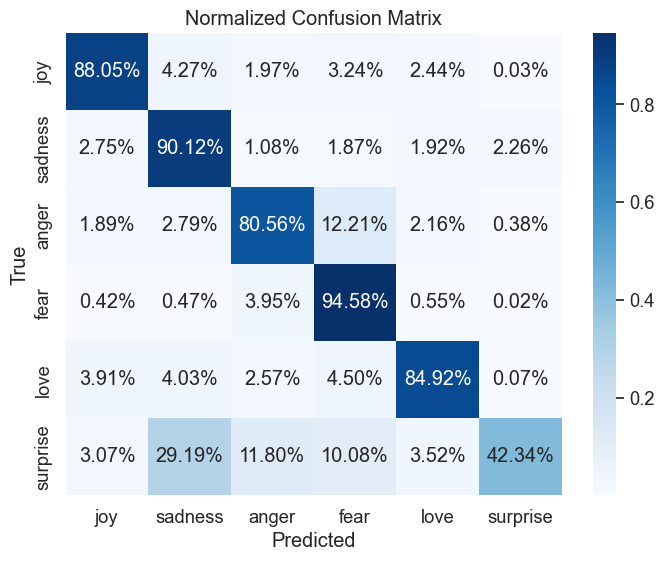

In [56]:

plot_confusion_matrix(ynb_pred)
# Show the plot
plt.show()

###  Random Forrest

In [46]:
rf = RandomForestClassifier(n_estimators=1)
rf.fit(X_train_vect, y_train)

yrf_pred = rf.predict(X_test_vect)

Accuracy: 49.62%

F1 Score: 49.62

COnfusion Matrix:
 [[ 6270  1168  1234   878  1531   663]
 [ 1079  4962   888   611   998  1005]
 [ 2799  2465 13150  4256  3643  2042]
 [  528   408  1144  3841   668   322]
 [ 3088  2675  3217  2089 11878  1462]
 [  219   473   298   203   241  1561]]


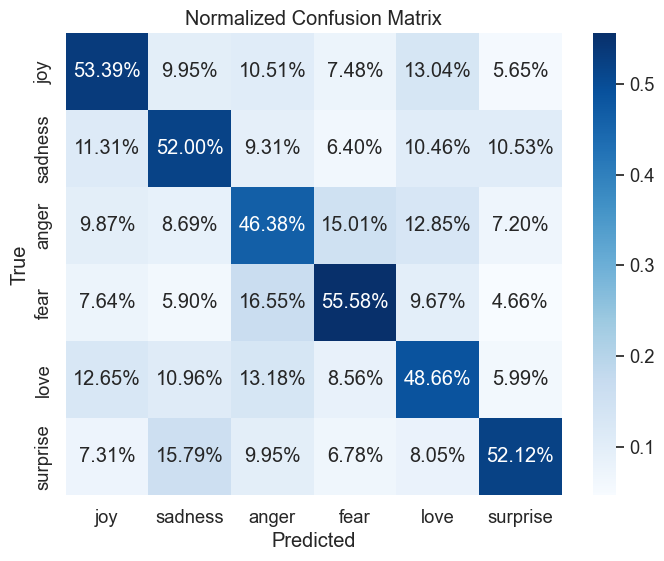

In [47]:
plot_confusion_matrix(yrf_pred)

# Show the plot
plt.show()

###  Logistic Regression

In [10]:
log = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1000)
log.fit(X_train_vect, y_train)

ylog_pred = log.predict(X_test_vect)

#3m 28.6s

Accuracy: 89.35%

F1 Score: 89.35

COnfusion Matrix:
 [[10919   342   128    86   213    56]
 [  322  8150    97    53   143   778]
 [  399   208 24622  2248   446   432]
 [   29    10   207  6606    29    30]
 [  951   622   476   250 21953   157]
 [    5   177    29    10     9  2765]]


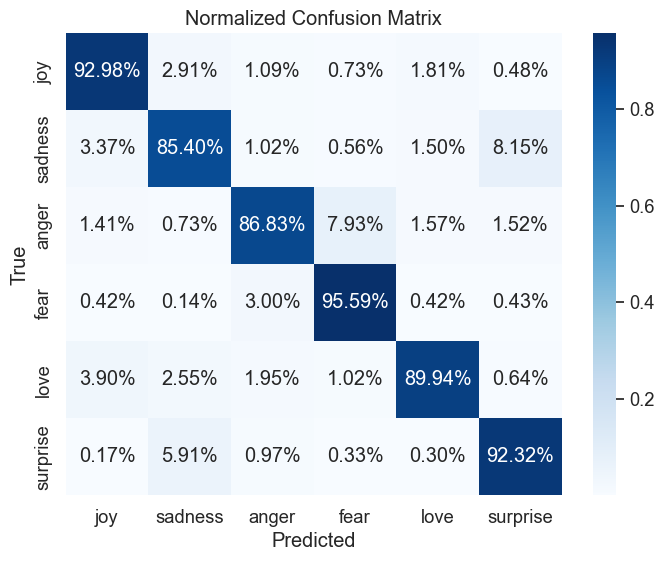

In [11]:
plot_confusion_matrix(ylog_pred)

# Show the plot
plt.show()

###  Linear Support Vector

In [57]:
svc = LinearSVC(tol=1e-05)
svc.fit(X_train_vect, y_train)

ysvm_pred = svc.predict(X_test_vect)

Accuracy: 89.93%

F1 Score: 89.93

COnfusion Matrix:
 [[16381   605   137   108   330    55]
 [  434 12342    90    62   230  1156]
 [  500   296 37202  3448   485   602]
 [   25    14   440  9826    29    33]
 [ 1297   901   380   303 33537   195]
 [    6   417    65    20    23  3961]]


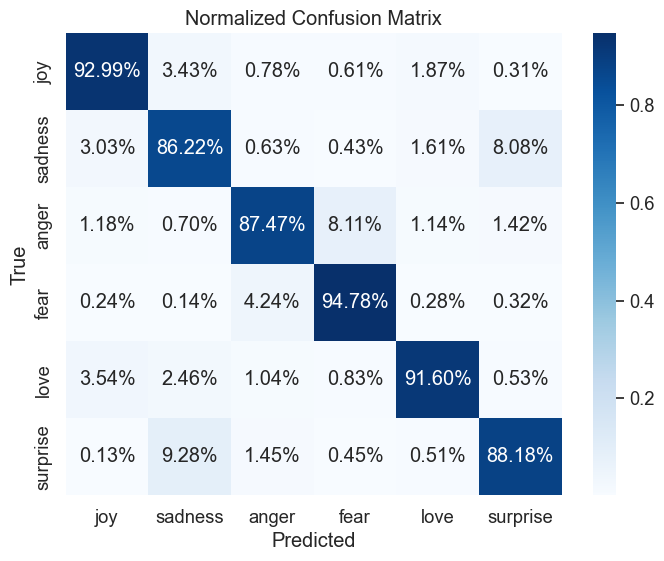

In [58]:
plot_confusion_matrix(ysvm_pred)

# Show the plot
plt.show()

## 4. Saving the tf-idf + SVM Model 


In [59]:
#Create pipeline with our tf-idf vectorizer and LinearSVC model
svm_model = Pipeline([
    ('tfidf', vect),
    ('clf', svc),
])

In [60]:
# save the model
filename = 'models/tfidf_svm.sav'
pickle.dump(svm_model, open(filename, 'wb'))

In [61]:
model = pickle.load(open(filename, 'rb'))

message = 'delivery was hour late and my pizza is cold!' 
model.predict([message])

array(['anger'], dtype=object)

In [62]:
message = 'I am shocked!' 
model.predict([message])

array(['surprise'], dtype=object)

In [69]:
message = 'This amazes me!' 
model.predict([message])

array(['joy'], dtype=object)

In [67]:
message = 'Truly upsetting.' 
model.predict([message])

array(['sadness'], dtype=object)

In [65]:
message = 'Today is my lucky day!' 
model.predict([message])

array(['joy'], dtype=object)

In [66]:
message = 'I feel really scared' 
model.predict([message])

array(['fear'], dtype=object)

The dataset is quite small, so it may not know certain words. This results in overfitting and thus poor generalization of the model.

Here's an example of misclassification:

In [73]:
fear_example = df[df['emotions'] == 'fear'].tail(10)

fear_example

,text,emotions
419945,i had not put in enough long sixty to seventy ...,fear
419956,i would look at other people like they were pe...,fear
419957,i feel very unsure on how to train the va writ...,fear
420001,i slept together because we both feel incredib...,fear
420002,i don t think so not the way he would feel me ...,fear
420011,i walked into irinas class last night feeling ...,fear
420030,i am his fianc e so i think he will make me fe...,fear
420039,i feel totes weird,fear
420048,im tired and a little irrational and wearing t...,fear
420062,i take every day as it comes i m just focussin...,fear


In [23]:
message = 'This house is spooky!' 
model.predict([message])

array(['sadness'], dtype=object)